Give me a datafram with two columns: time and ndvi.  I'll assume they are in that order.
I'll give you daily, interpolated NDVI from the first day to the last
columns will be 'time','ndvi','ndvi_smoothed'. the first ndvi is jsut interpolated.
AND I'll give you the savgol point at each of your original inputs

In [104]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter

In [123]:
#
# Find outliers
# An outlier is any ndvi that has an abs(zscore) > 1 AND that is substantially
# far away from the mean in absolute terms as well. (delta > 0.2)
# the latter condition avoid us dropping a point with a zscore just becasue the
# series has been constant for several days and then starts moving a little bit
#
def find_outliers(m2):
    # compure zscore for every point using two points before and two points after each point
    window_size = 7
    rolling_mean = m2['ndvi'].rolling(window=window_size, center=True).mean()
    rolling_std = m2['ndvi'].rolling(window=window_size, center=True).std()

    # Calculate the z-score for each point
    m2['rolling mean'] = rolling_mean
    m2['rolling std'] = rolling_std
    m2['zscore'] = (m2['ndvi'] - rolling_mean) / rolling_std
    m2['delta'] = m2['ndvi'] - m2['rolling mean']
    m2['outlier'] = (m2['delta'].abs() > 0.2) & (m2['zscore'].abs() > 1.5)
    return m2

def remove_outliers(m):
    m1 = m.copy()
    m1 = find_outliers(m1)
    m2 = m1[m1['outlier']==False]
    print(f"removed {m1.shape[0] - m2.shape[0]} outliers")
    y = pd.DataFrame()
    y['time'] = m2['time'].values
    y['ndvi'] = m2['ndvi'].values
    return y


In [124]:
def savgol(df_,window_length=20,polyorder=2):
    # rename the first column as 'time' and the second as 'ndvi'
    m = pd.DataFrame()
    m['time'] = df_['time']
    m['ndvi'] = df_['ndvi'] # !!!
    m = remove_outliers(m)
    min_date = m["time"].min()
    max_date = m["time"].max()
    date_range = pd.date_range(min_date, max_date, freq='D')
    m1 = pd.DataFrame({"time": date_range})

    # Merge the original 'ndvi' values into the new DataFrame 'm1' using outer join
    m1 = pd.merge(m1, m, on="time", how="left")

    # Interpolate missing values in the 'ndvi' column
    m1["ndvi"] = m1["ndvi"].interpolate()

    # Fill missing values with NaN, so the filter doesn't treat them as zeros
    m1["ndvi"] = m1["ndvi"].replace(0, np.nan)

    # Apply the savgol_filter to smooth the "ndvi" column
    m1["ndvi_smoothed"] = savgol_filter(m1["ndvi"], window_length, polyorder)

    l = []
    for t in m['time'].values:
        ndvi_value = m1[m1['time']==t]['ndvi_smoothed'].values[0]
        l.append(ndvi_value)
    m['savgol point'] = l
    return [m1,m]






In [131]:
m = pd.read_parquet('data/s2l8.parquet')
lats = m['lat'].unique()
lat = lats[0]
m1 = m[m.lat==lat]
m1 = m1[['time','ndvi']]
fitted,original = savgol(m1,window_length=20,polyorder=2)


removed 1 outliers


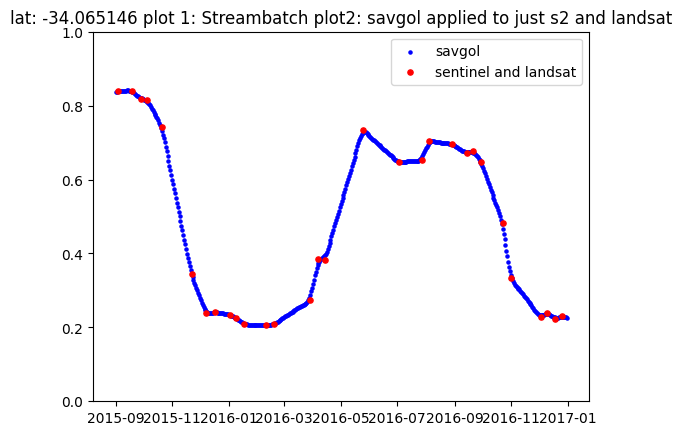

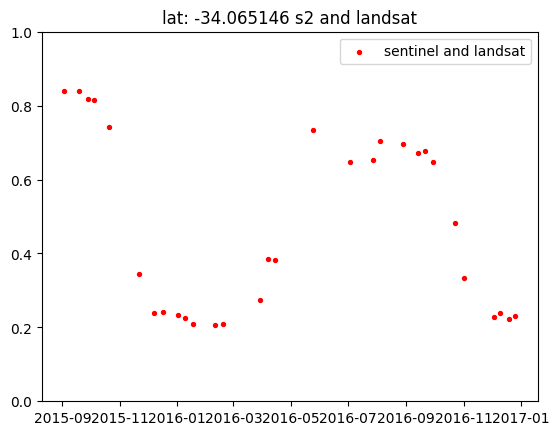

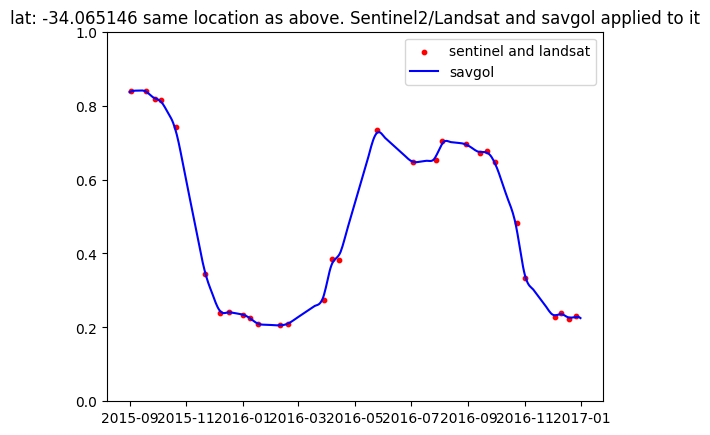

lat: -34.065146


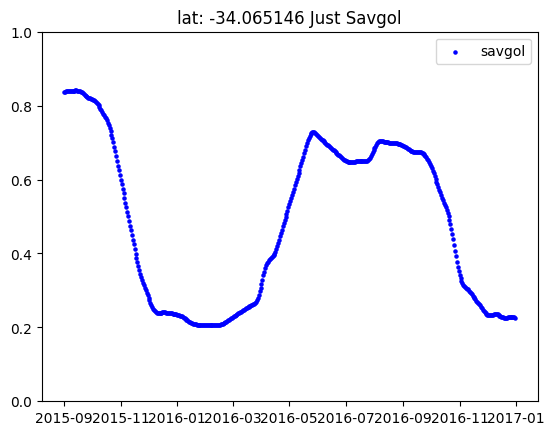

In [132]:
import matplotlib.pyplot as plt
start_date = '2015-09-01'
end_date = '2016-12-31'

fitted = fitted[fitted['time'] >= start_date]
fitted = fitted[fitted['time'] <= end_date]

m1 = m1[m1['time'] >= start_date]
m1 = m1[m1['time'] <= end_date]

plt.scatter(fitted['time'], fitted['ndvi_smoothed'], label='savgol',s=5,color='blue')
plt.scatter(m1['time'], m1['ndvi'], label='sentinel and landsat',s=14, color="red")
plt.title(f"lat: {lat} plot 1: Streambatch plot2: savgol applied to just s2 and landsat")
plt.legend()
plt.ylim(0, 1.0)
plt.show()

plt.scatter(m1['time'], m1['ndvi'], label='sentinel and landsat',s=8, color="red")
plt.title(f"lat: {lat} s2 and landsat")
plt.legend()
plt.ylim(0, 1.0)
plt.show()

plt.scatter(m1['time'], m1['ndvi'], label='sentinel and landsat',s=10, color="red")
plt.plot(fitted['time'], fitted['ndvi_smoothed'], label='savgol', color='blue')
plt.title(f"lat: {lat} same location as above. Sentinel2/Landsat and savgol applied to it")
plt.legend()
plt.ylim(0, 1.0)


plt.show()
print(f"lat: {lat}")
plt.scatter(fitted['time'], fitted['ndvi_smoothed'], label='savgol',s=5, color='blue')
plt.title(f"lat: {lat} Just Savgol")
plt.ylim(0, 1.0)
plt.legend()

plt.show()